In [ ]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#데이터 불러오기(경로)
train_x_df = pd.read_csv('/content/drive/MyDrive/capstone2021/train_x_df.csv')
train_y_df = pd.read_csv('/content/drive/MyDrive/capstone2021/train_y_df.csv')
test_x_df = pd.read_csv('/content/drive/MyDrive/capstone2021/test_x_df.csv')
sample_submission=pd.read_csv('/content/drive/MyDrive/capstone2021/sample_submission.csv')
merged_df=pd.read_hdf('/content/drive/MyDrive/capstone2021/merged_data.h5')
train_x_df = train_x_df.astype('float')
train_y_df = train_y_df.astype('float')
test_x_df = test_x_df.astype('float')
sample_submission=sample_submission.astype('float')

In [ ]:
# 3차원 array로 변경
def df2d_to_array3d(df_2d):

    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

# 코인별 인덱스 뽑기
def coin_index_export(input_array, coin_num):

    index = []
    sample_id_len = input_array.shape[0]
    coin_num_col = 0 

    for sample_id in range(sample_id_len):
        if input_array[sample_id, 0, coin_num_col] == coin_num:
            #print(sample_id)
            index.append(sample_id)
    return index


def kbindiscreter(input_array):
  kb = KBinsDiscretizer(n_bins=100, strategy='uniform', encode='ordinal')
  processed_data = np.zeros((input_array.shape[0], input_array.shape[1], 1))
  for i in range(input_array.shape[0]):
    processing_array = input_array[i,:,1]
    kb.fit(processing_array.reshape(input_array.shape[1],1))
    processed_fit = kb.transform(processing_array.reshape(input_array.shape[1],1))
    processed_data[i,:,:] = processed_fit
  return processed_data

In [ ]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)
merged_array = df2d_to_array3d(merged_df)

In [ ]:
xarray = kbindiscreter(train_x_array)
yarray = kbindiscreter(train_y_array)

In [ ]:
#바꿀 데이터
df2 = xarray[:100,:,:].reshape(100,1380,1)

In [ ]:
X_train = []
y_train = []
n_future = 1 # Number of days we want to predict into the future.
n_past = 24 # Number of past days we want to use to predict future.
for idx in range(df2.shape[0]):
    for i in range(n_past, df2.shape[1] - n_future +1):
        X_train.append(df2[idx, i - n_past:i,:])
        y_train.append(df2[idx, i:i+n_future, :])
X_train, y_train = np.array(X_train), np.array(y_train)
print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (135600, 24, 1).
y_train shape == (135600, 1, 1).


In [ ]:
#X 원 핫 인코딩
x_traina = np.zeros((X_train.shape[0],X_train.shape[1],100))
for i in range(X_train.shape[0]):
  for j in range(X_train.shape[1]):
    for k in range(100):
      if X_train[i,j,:] ==k:
        x_traina[i,j,k] =1

In [ ]:
#Y 원 핫 인코딩
y_traina = np.zeros((y_train.shape[0],100))
for i in range(y_train.shape[0]):
  for j in range(100):
    if y_train[i] == j:
      y_traina[i,j] = 1

In [ ]:
model = Sequential()

model.add(Conv1D(64,10, activation='relu', input_shape=(x_traina.shape[1],x_traina.shape[2] )))
model.add(Conv1D(64,5, activation='relu'))
model.add(Conv1D(32,4, activation='relu'))
model.add(Conv1D(16,4, activation='relu'))
model.add(MaxPooling1D(4))


model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=100, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_traina,y_traina,epochs=50, validation_split=0.2,shuffle=True)

In [ ]:
# train 값 plotting

aa =x_traina[729:829,:,:] 
bb =y_traina[729:829,:]
predictions = model.predict(aa.reshape(100,24,100))

In [ ]:
# prediction 값 원 핫 인코딩 -> '정수값
fa = []
for i in range(100):
  fc = model.predict(aa[i].reshape(1,24,100))
  fa.append(np.argmax(fc))

In [ ]:
# real 값 원 핫 인코딩 -> '정수값
fb = []
for i in range(100):
  fb.append(np.argmax(bb[i]))

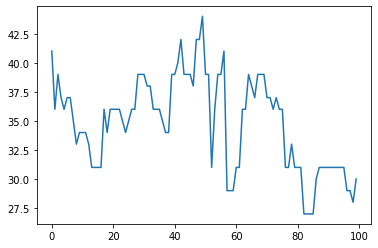

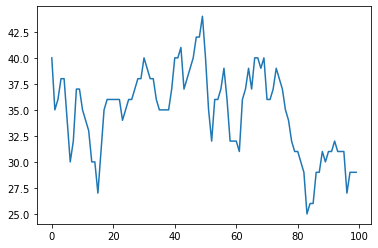

In [ ]:
#plotting
plt.plot(fa, label="predictions")
plt.show()
plt.plot(fb, label="real")


In [ ]:
#train set auto regression

aa =x_traina[800,:,:]
yhat=[]
x= aa.reshape(1,24,100)


In [ ]:
for i in range(100):
  x=x.reshape(1,24,100)
  fc = model.predict(x)
  yhat.append(np.argmax(fc))
  fd = np.zeros((1,100))
  for j in range(100):
    if j==np.argmax(fc):
      fd[0,j] = 1
  
  x=x.reshape(24,100)
  x=np.vstack([x,fd])
  x=x[1:,:]

In [ ]:
bb = []
for x in range(100):
  bb.append(np.argmax(y_traina[800+x]))


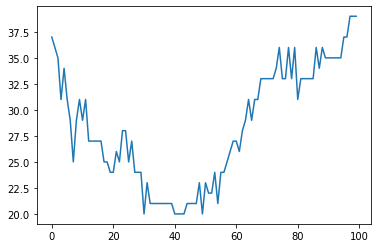

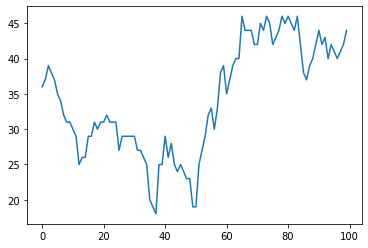

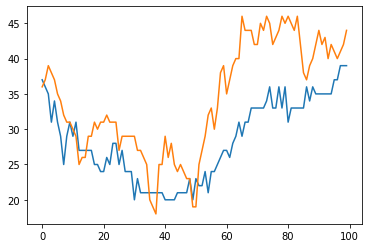

In [ ]:
# train set auto regression plotting
plt.plot(yhat,label="prediction")
plt.show()
plt.plot(bb, label="real")
plt.show()
plt.plot(yhat,label="prediction")
plt.plot(bb, label="real")

In [ ]:
#val set auto regression

aa =x_traina[61395,:,:]
yhat=[]
x= aa.reshape(1,24,100)


In [ ]:
for i in range(100):
  x=x.reshape(1,24,100)
  fc = model.predict(x)
  yhat.append(np.argmax(fc))
  fd = np.zeros((1,100))
  for j in range(100):
    if j==np.argmax(fc):
      fd[0,j] = 1
  
  x=x.reshape(24,100)
  x=np.vstack([x,fd])
  x=x[1:,:]


In [ ]:
bb = []
for x in range(100):
  bb.append(np.argmax(y_traina[61395+x]))

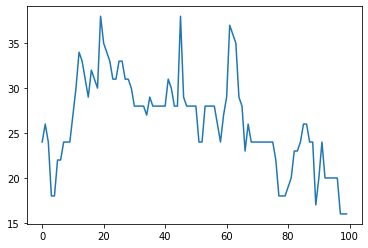

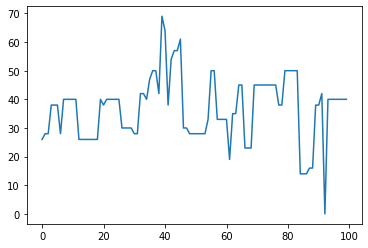

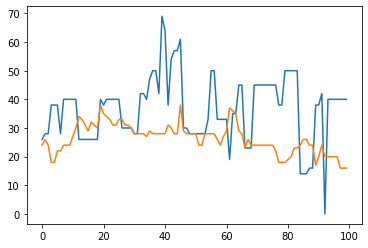

In [ ]:
plt.plot(yhat,label="prediction")
plt.show()
plt.plot(bb, label="real")
plt.show()
plt.plot(bb, label="real")
plt.plot(yhat,label="prediction")